# **DSCI 100 Group Project: A Classification Analysis on Student Knowledge Level.**
DSCI 100 - Section 002. 
Contributers: Tara Treagus, Teevint Prak, Michelle Benitez-Muller, Ayush Joshi

## **Introduction**

In this report we aimed to predict the knowledge level of students from certain predictors. The available predictor candidates pertained to the study time, degree of repetition and exam performance of students. An effective model which determines user knowledge levels can be used to provide insight on students’ actual levels of material retention. Although test scores give insight on the comprehension of the student, they prove to not always be a complete representation of knowledge level. Exploration of student learning concluded that standardized tests are very limited in the information they can provide about a student's knowledge (Schneider, 2017). Therefore, we will statistically explore the predictors to determine which provide the most accurate estimate of student knowledge level.

This is a classification problem because the target variable is a non-numeric, categorical variable, whose class will be predicted. Regression models would not be effective in this setting as we are trying to assign an observation with a certain class, not predict its numerical value. Our classification model was built using the K-nearest neighbor algorithm (KNN). KNN works by finding the (K) number of points with the closest distance to a data point with unknown class. From the neighbouring points, the majority class classifies the new point as such. Our KNN classification model was trained and tuned using a training data subset, then evaluated on test data. The accuracy and confusion matrix from test data predictions determined the model’s ability to correctly predict the classes of new data.

The User Knowledge Modeling data set about students' knowledge of Electrical DC Machines, from the UCI Machine Learning Repository was used in this model. This is a multivariate data set, including five predictors and the target variable. Preliminary data analysis was performed to determine which predictors should be used to produce the most effective classification model.

Our final model answers the question, what is the predicted knowledge level of a student on subject matter based on exam performance for goal objects and exam performance on related objects to goal object?

## **Method**

To start, there are a number of preliminary steps which must be performed. These include reading the data from the web, wrangling the data into a tidy format and performing a preliminary analysis. A preliminary analysis will be performed to help familiarize ourselves with the data and determine which predictors should be used in the classification model. The very first step in our analysis is to set the seed and load all the libraries we will be needing. Setting the seed ensures that our analysis is reproducible by specifying functions that produce random results to run the same results each time, and loading the libraries loads all the functions we will need to use in this analysis into our directory.

In [64]:
library(tidyverse)
library(repr)
library(cowplot)
library(readxl)
library(tidymodels)
library(testthat)
library(digest)
library(repr)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

## **Reading the Data**

Before we can begin building our classifier, we must first load our data set and explore the data. Because we are working with data from the web, we need to first assign the remote data set’s URL to an object named, `url` then use the `download.file()` function to download the data into our directory. We created a folder in our directory to store the data named, “data”. Because the data is formatted as an excel file, we will then use the `read_excel` function to read the data and assign it to a tibble named `user_data`. In the read_excel function, we tell R to read the second sheet of the Excel file using the argument, `sheet = 2`

In [65]:
#Obtaining the url of the data set
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"

#Downloading the file into specified directory 
download.file(url, dest = "data/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls")

#Data is an excel in sheet 2, so we use read_excel with sheet = 2. 
user_data_raw <- read_excel(path = "data/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", sheet = 2)
user_data_raw

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS,...7,...8,Attribute Information:
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low,NA,NA,"STG (The degree of study time for goal object materails),"
0.08,0.08,0.10,0.24,0.90,High,NA,NA,SCG (The degree of repetition number of user for goal object materails)
0.06,0.06,0.05,0.25,0.33,Low,NA,NA,STR (The degree of study time of user for related objects with goal object)
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High,NA,NA,NA
0.50,0.75,0.81,0.61,0.26,Middle,NA,NA,NA
0.66,0.90,0.76,0.87,0.74,High,NA,NA,NA


**Figure 1.** A tibble of the dataframe directly read from the excel file using `read_excel`. 

## **Wrangling the Data**

The data loaded from the web in the tibble, Figure 1, is not in a tidy format. We must take steps to wrangle it, removing unnecessary columns and ensuring that each column represents one attribute, and each row represents one observation. We use the `select` function to select only the columns, `STG`, `SCG`, `STR`, `LPR`, `PEG`, and `UNS`, which are the predictor and target variables. All other columns will not be needed in our analysis so can be removed. We can then check if there is any missing data (“NA’s”) in the data set using the functions, `sum` and `is.na`, specifying our dataset as `user_data`.

user_data <- user_data_raw %>% select(STG, SCG, STR, LPR, PEG, UNS) %>%
             mutate(UNS = as_factor(UNS)) %>% 
             mutate(UNS = fct_reorder(UNS, STG))
             
user_data

**Figure 2.0.** The wrangled dataframe from the Figure 1 that keeps only the important variables.

In [66]:
user_data_na <- tibble(Num_of_NAs = sum(is.na(user_data)))
user_data_na

Num_of_NAs
<int>
0


**Figure 2.1.** A tibble of the number of missing values in the user_data dataframe. There are 0 missing values. 

Based on Figure 2.1, there were no missing values for all the variables, so we can consider all of them as predictor candidates for our classifier.

## **Preliminary Data Analysis**

We begin by defining each predictor and the target variable. From the information received from the website hosting the data we conclude:

- STG is the degree of study time for goal object materails. (predictor value)
- SCG is the degree of repetition number of user for goal object materails. (predictor value)
- STR is the degree of study time of user for related objects with goal object. (predictor value)
- LPR is the exam performance of user for related objects with goal object. (predictor value)
- PEG is the exam performance of user for goal objects. (predictor value)
- UNS is the knowledge level of user. (target value)

Our target variable is the knowledge level of user (`UNS`). Our predictor variable candidates are STG, SCG, STR, LPR and PEG. Investigating the definitions of each predictor variable, we see that the variables are divided into activities/ scores for “goal objects” and for “related object with goal object”. The goal object variables apply directly to the subject of which the user knowledge level is being tested, while the related object variables refer to areas of study which are related to the tested subject. We can assume from this that the goal object variables, (STG, SCG and PEG) could be more effective predictors in our classification model. 

At the same time, we may also need to consider `LPR` and `PEG` as our predictors. They could also be better predictors, since exam performances might be more relevant with user knowledge level than the degree of study time or repitition. After all, in courses such as DSCI, passing or failing the course depends on your grade which is mainly decided by exam performances. This is also true, for most courses. So logically, it make sense that `LPR` and `PEG` could be more relevant to the user knowledge level. 


Although this is just a conceptual hypothesis. So to confirm, we will use ggpairs to visualize the relationships and add on mapping to help discern between the labels.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



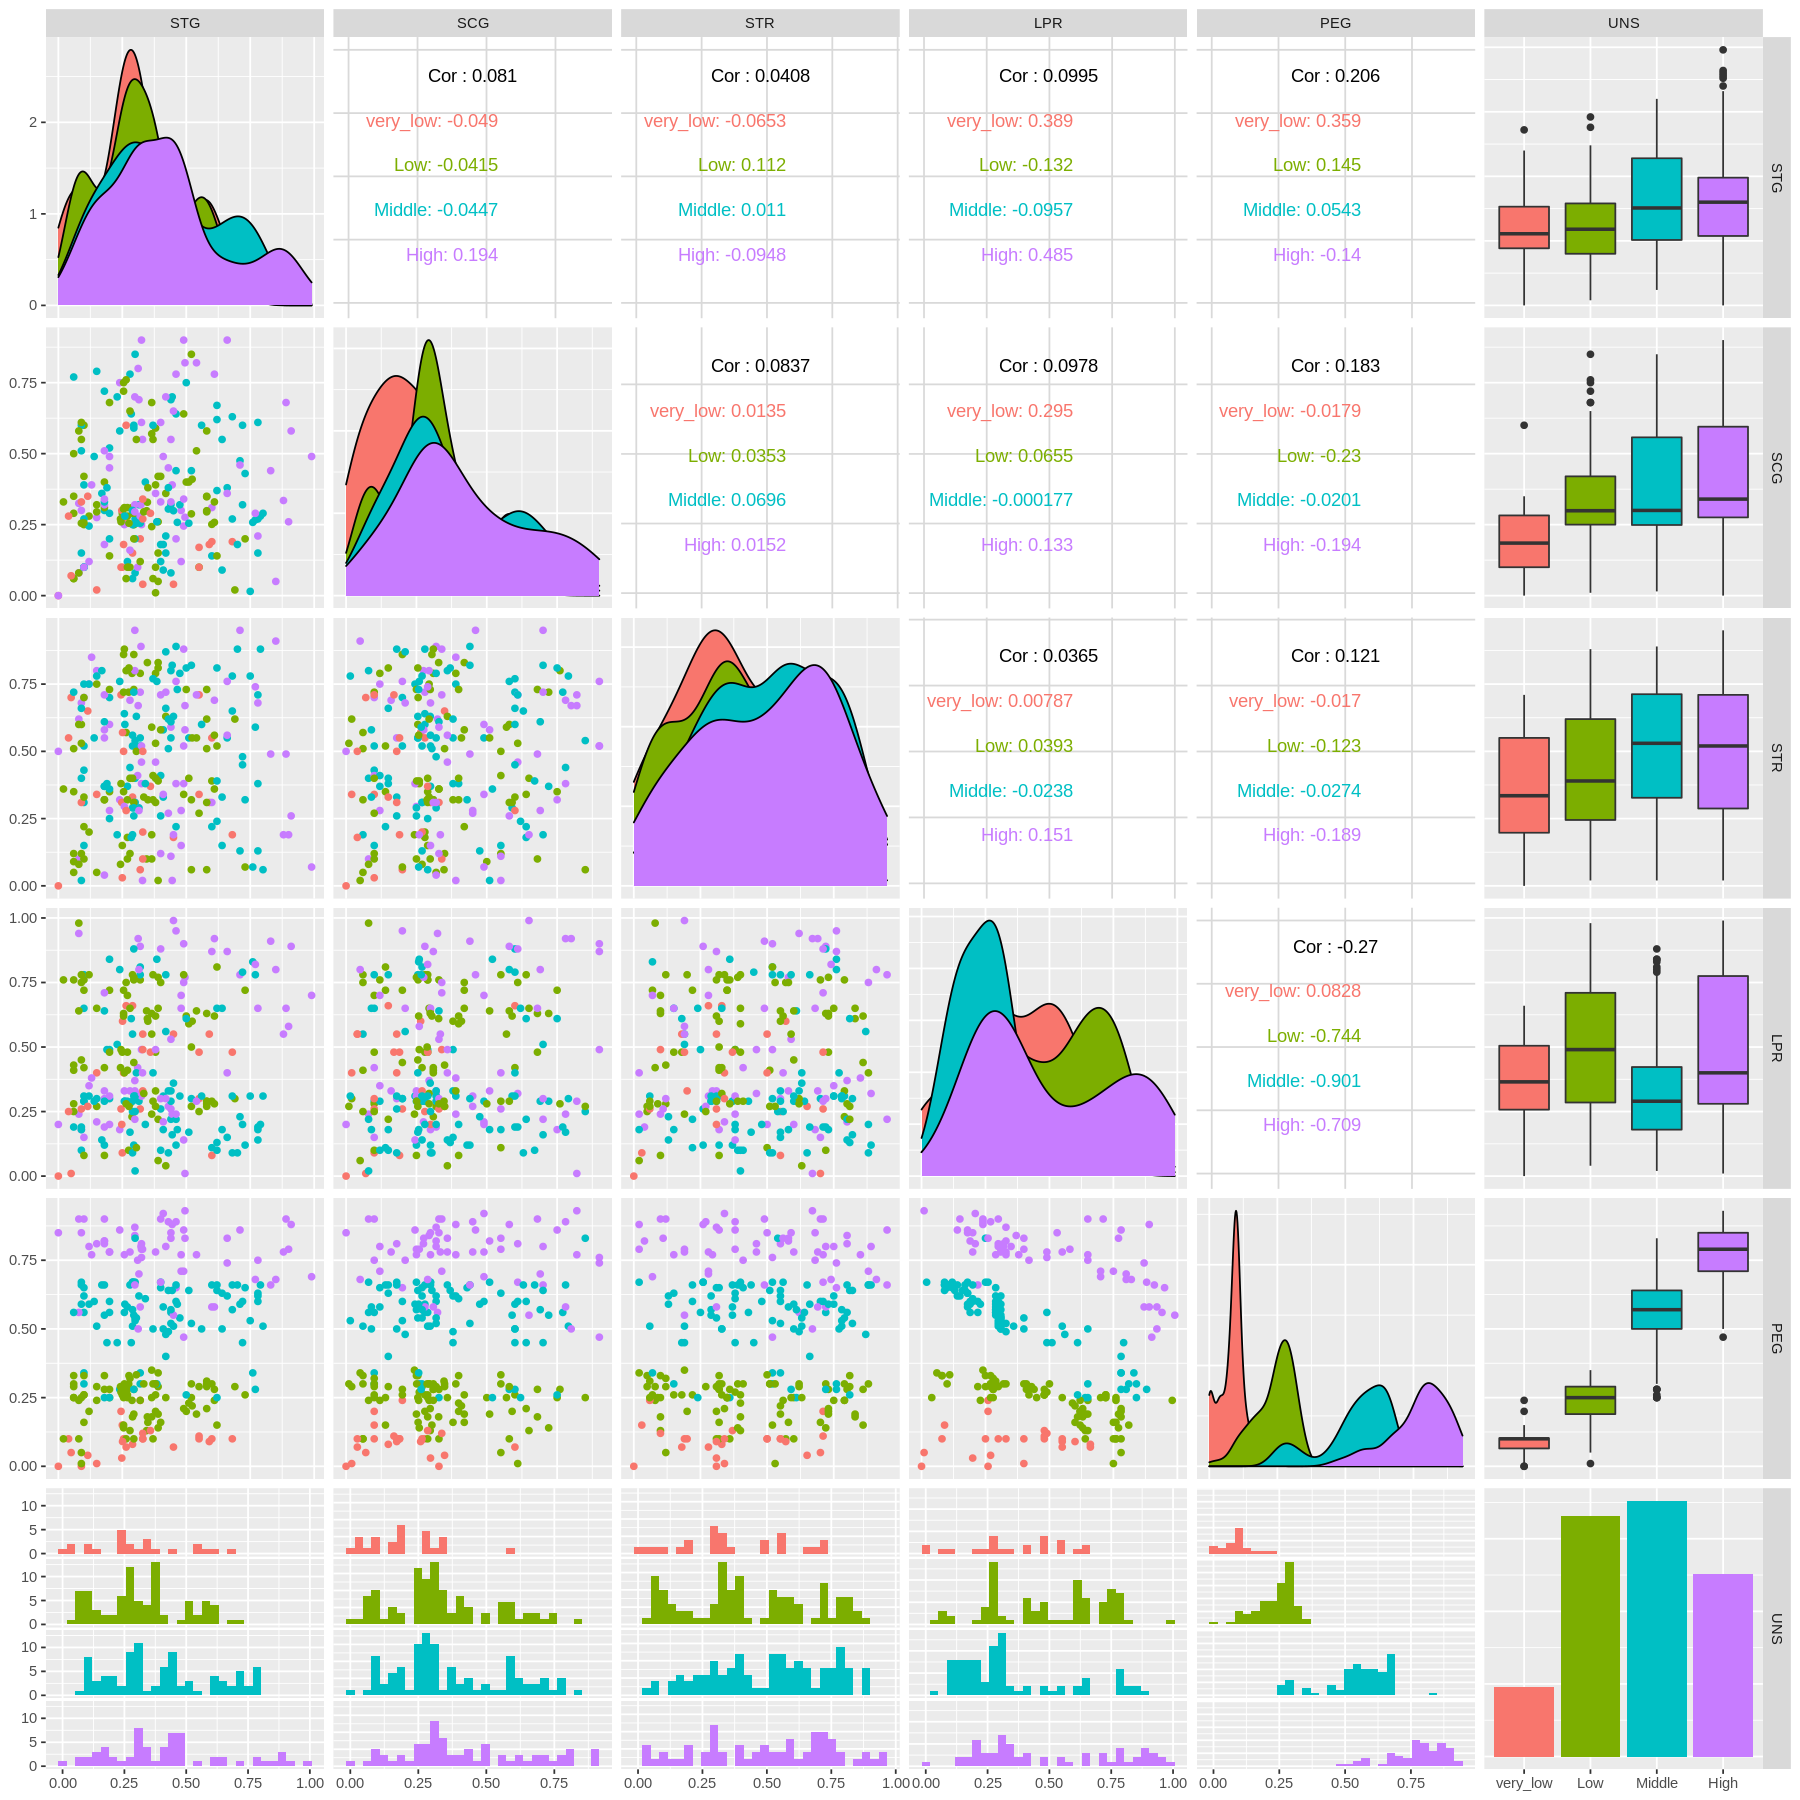

In [67]:
options(repr.plot.width=15, repr.plot.height=15)
pairs_plot <- ggpairs(user_data, columns = 1:6, mapping=ggplot2::aes(colour = UNS))
pairs_plot

**Figure 3.0.** The ggpairs visualization of the relationships between all the variables in `user_data` with many different type of plots.

### **Choosing Predictors**

Based on this visualization in Figure 3.0, we can see that the scatter plots in the second to bottom row of `ggpairs` with (`PEG`) has shown any kind of relationship or pattern. The noticeable pattern across these plots with `PEG` are the 4 clusters that represents different user knowledge levels (`UNS`). Based on these plots, the higher the clusters, the greater the `PEG`, the greater their user knowledge level `UNS` as coloured. That means that there seems to be a strong postive relationship between `PEG` values and `UNS` levels. Therefore, exam performance on goals (`PEG`) could be a good predictor in training our classifier to predict user knowledge (`UNS`). 

Although PEG maybe a great predictor, having a second relevant predictor to train our classifier might yield better results as their is more information for the classifer to train from. And we believe `LPR` is a great candidate, because out of the 4 `PEG` scatter plots, the `LPR` and `PEG` plot has shown the cleanest seperation between the 4 tightly gathered clusters that represents distinct UNS levels. This means there is less overlap between clusters. And since the classifier uses the knn-algorithm, which predicts the class of an unclassified point based on its neighbours, less overlap helps the classifier in accurately distinguish the class of an unknown point. So with the least overlap in their scatter plot in Figure 3.0, LPR and PEG could be great predictors to train our classifier. 

We could have more than 2 predictors, but we believed that exam performance on goals (`PEG`) and on related goals (`LPR`) are the most relevant to the userknowledge. As mentioned earlier in the later paragraphs before we perform ggpairs, that exam performances might be more relevant to user knowledge than the degree of study time or repition. And with ggpairs, we see that the scatter plot of `PEG` and `LPR` has a stronger relationship than the other plots. So we conclude that adding the other predictors may decrease the accuracy of our classifier as they might be less relevant in deciding the user knowledge (`UNS`). 

### **Summary Table**
For our summary table, we want to see the number of observations per label to investigate a possible class imbalance in our data. If there is a class imbalance, then we might need to upsample our dataset prior to training it. 

In [68]:
user_data_count <- user_data %>%
    group_by(UNS) %>%
    summarize(count = n())
user_data_count

`summarise()` ungrouping output (override with `.groups` argument)



UNS,count
<fct>,<int>
very_low,24
Low,83
Middle,88
High,63


**Figure 3.1**, a table that displays the number of data points of each user knowledge level. 

From the table in Figure 3.1, we see that the `very_low` `UNS` label has less observations than the others. Although, we believe we may not need to upsample because we could prevent the bias in the classifier by choosing a smaller k number. For our data set, since very_low has 24 observations, then as long as we don't choose a k number greater than 48, the other labels can not always win the majority vote. We should also mention that the all the labels of `UNS` are equally weighted. Therefore, all of the labels are conceptually as important as one another. If `very_low` label was conceptually more important than the others, then we may need to upsample it so it has greater chance to be classified.

Overall, since there isn't a major class imbalance and all labels are equally weighted, as long as we choose a k number under 48, we do not need to upsample our data set. 


Now we also want to see if we need to scale or center the data. As part of the summary table, we can create a tibble of the mean, and standard deviation of LPR and PEG.  

In [69]:
mean_med_data <- summarize(user_data,
          LPR_mean = mean(LPR), 
          LPR_sd = sd(LPR),
          PEG_mean = mean(PEG), 
          PEG_sd = sd(PEG)) 

mean_med_data

LPR_mean,LPR_sd,PEG_mean,PEG_sd
<dbl>,<dbl>,<dbl>,<dbl>
0.4327132,0.248108,0.4585388,0.2552109


**Figure 3.2** A table of of the mean and standard deviation of our predictors, `LPR` and `PEG`. 

Since in Figure 3.2, the mean isn't 0 and standard deviation isn't 1, the data isn't standardized. Even if there weren't any scaling issues with our data as it all predictors value has been set to out 1, we still should scale and center our data to ensure our predictors are standardized. 

## **Training the classifer**

Now that we have tidied our data, and chosen our predictors, we can start building our classifier. First we start by splitting our data set into 75% for training and 25% for testing so that we have enough to train the classifier while having and test its predictions. To ensure this lab can be reproduced, we set the seed to 1234, to control the randomness of the splitting and training of the data. 

In [70]:
set.seed(1234)
user_split <- initial_split(user_data, prop = 0.75, strata = UNS)
user_train <- training(user_split)
user_test  <- testing(user_split)

Before we actually build the classifier itself, we need to find the optimal k for the knn-algorithm. We will use cross validation to perform 10 folds so that all sections of the data could be throughly tested against to find a good average of the accuracy. We decided to not go for more than 10 folds it will take too long to finish with the amount of data we have.

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

! Fold04: internal: No observations were detected in `truth` for level(s): 'very_l...

! Fold06: internal: No observations were detected in `truth` for level(s): 'very_l...

! Fold07: internal: No observations were detected in `truth` for level(s): 'very_l...



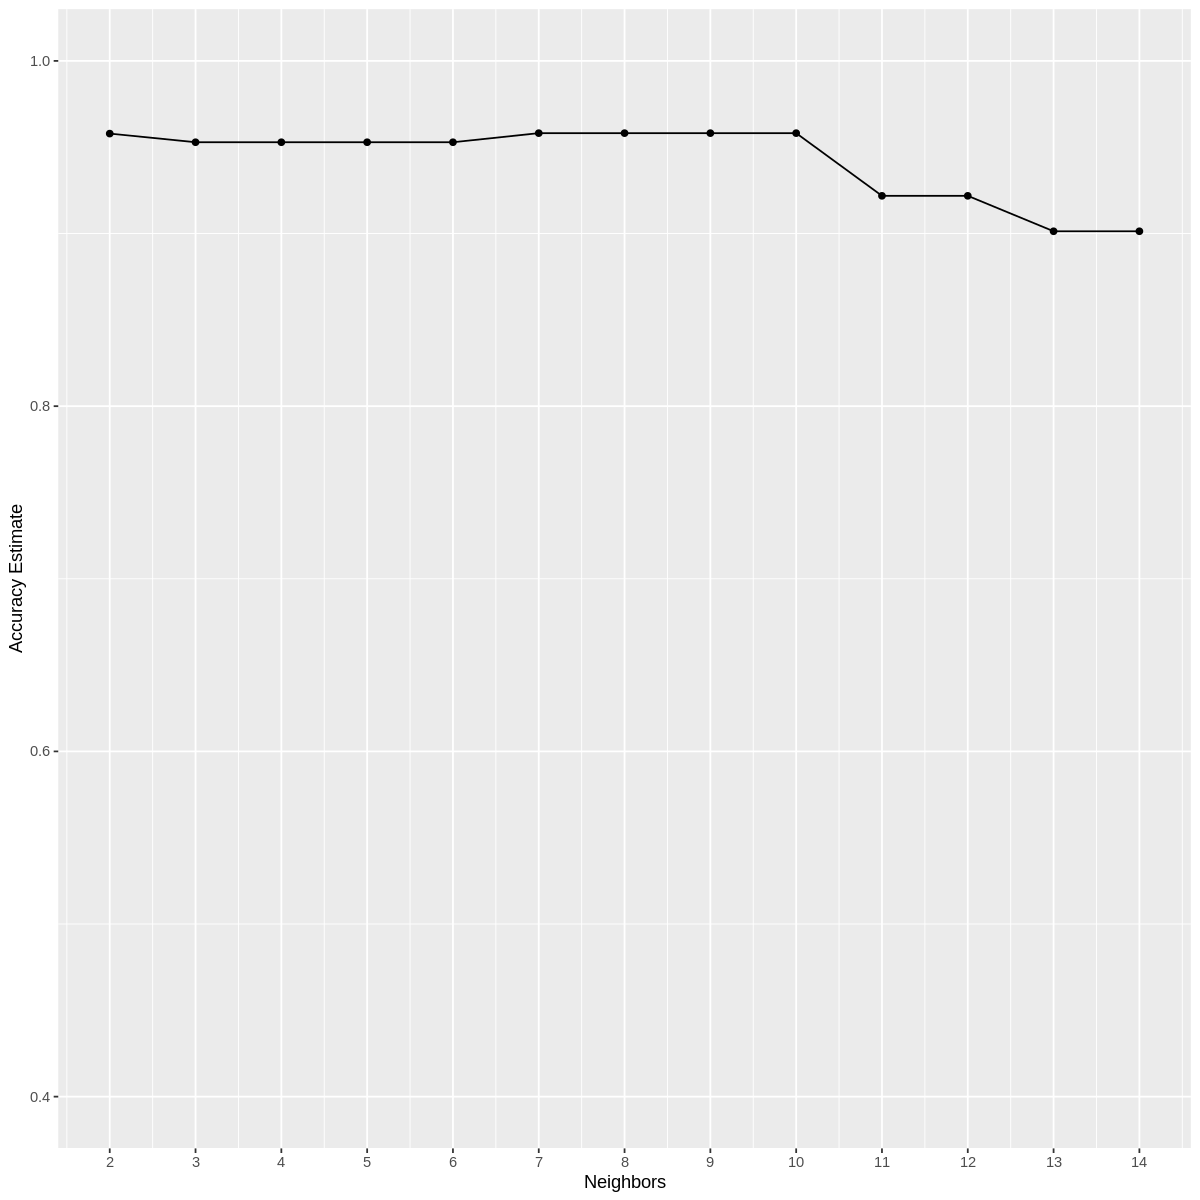

In [71]:
options(repr.plot.width=10, repr.plot.height=10)
#Creating the recipe to predict UNS with STG and PEG 
user_recipe <- recipe(UNS ~ PEG + LPR, data = user_train) %>%
      step_scale(all_predictors()) %>%
      step_center(all_predictors())
                
user_recipe

#Doing the vfold for cross_validation to find best K value
user_vfold <- vfold_cv(user_train, v = 10, strata = UNS)

#Getting knn_tune for the workflow
knn_tune <-  nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

#Collecting the results of which is best k value
knn_results <- workflow() %>%
       add_recipe(user_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = user_vfold, grid = 20) %>%
       collect_metrics()

#Plotting the K value accuracies
accuracies <- knn_results %>% 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

**Figure 4.0.** A line plot of the accuracy estimates of the classifier vs the k number. 

From the line plot in Figure 4.0, we see that the accuracy estimates decreases for k > 6. It could be caused that k > 6 the prediction is being generalized and average with too many data points too far from the unclassified points. So now we will choose k = 5, because it has the highest accuracy estimates. Even though k = 6 has a similar accuracy, an even k number could cause a tie in the vote when their the same number of label. |

Now, we will now build the classifier itself with neighbours = 5. 

In [72]:
#Now that we got the best k value, which is 2, we now use it to predict
user_spec <-  nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
       set_engine("kknn") %>%
       set_mode("classification")

user_fit <- workflow() %>%
       add_recipe(user_recipe) %>%
       add_model(user_spec) %>%
       fit(data = user_train)

user_predict <- predict(user_fit, user_test) %>%
                bind_cols(user_test) 
user_predict 

.pred_class,STG,SCG,STR,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Middle,0.08,0.08,0.08,0.98,0.24,Low
High,0.00,0.00,0.50,0.20,0.85,High
High,0.18,0.18,0.55,0.30,0.81,High
⋮,⋮,⋮,⋮,⋮,⋮,⋮
High,0.89,0.68,0.49,0.65,0.90,High
Middle,0.72,0.60,0.45,0.79,0.45,Middle
Middle,0.56,0.60,0.60,0.31,0.50,Middle


**Figure 4.1.** A table of the data frame and the classifier's predictions in `.pred_class` column. 

In [73]:
user_metrics <- user_predict %>%
         metrics(truth = UNS, estimate = .pred_class)
user_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9206349
kap,multiclass,0.8894737


**Figure 4.2.** A table displaying the accuracy of the classifier agaisnt the testing data. It has an accuracy of 92%, which means it can correctly predicted 92% of the testing data. 

In [74]:
user_conf_mat <- user_predict %>% 
       conf_mat(truth = UNS, estimate = .pred_class)
user_conf_mat

          Truth
Prediction very_low Low Middle High
  very_low        5   0      0    0
  Low             3  18      0    0
  Middle          0   1     20    1
  High            0   0      0   15

**Figure 4.3.**, This is a truth matrix that shows the number of predictions that matches with the actual data, and if wrongly predicted what the classifer chose instead. The diagnoal row accross the matrix are the correct predictions and those rest are the wrongly predicted ones. 

From Figure 4.3, with an accuracy of 92% from Figure 4.2, we believe this is quite an accurate classifier. Although personally we do not believe it is very relaible as it made mistakes with `very_low` data points. It could be cause from the lack of training data of `very_low` points. Another cause of these mistakes is due to the overlaps between the `very_low` and `low` clusters of data causing the classifer to be confuseded by the two. 

To better illustrate this the region the classifier would predict, we will create a scatter plot with the color regions of where the data classifier would label unknown points as. We will create a normal scatter plot of the original data but with an extra geom_point that uses mapping with y = Class. We should also mention that this visualization was only possible with 2 predictors since a 3 dimensional or 4 dimensional graph would be hard to build and interpret. 

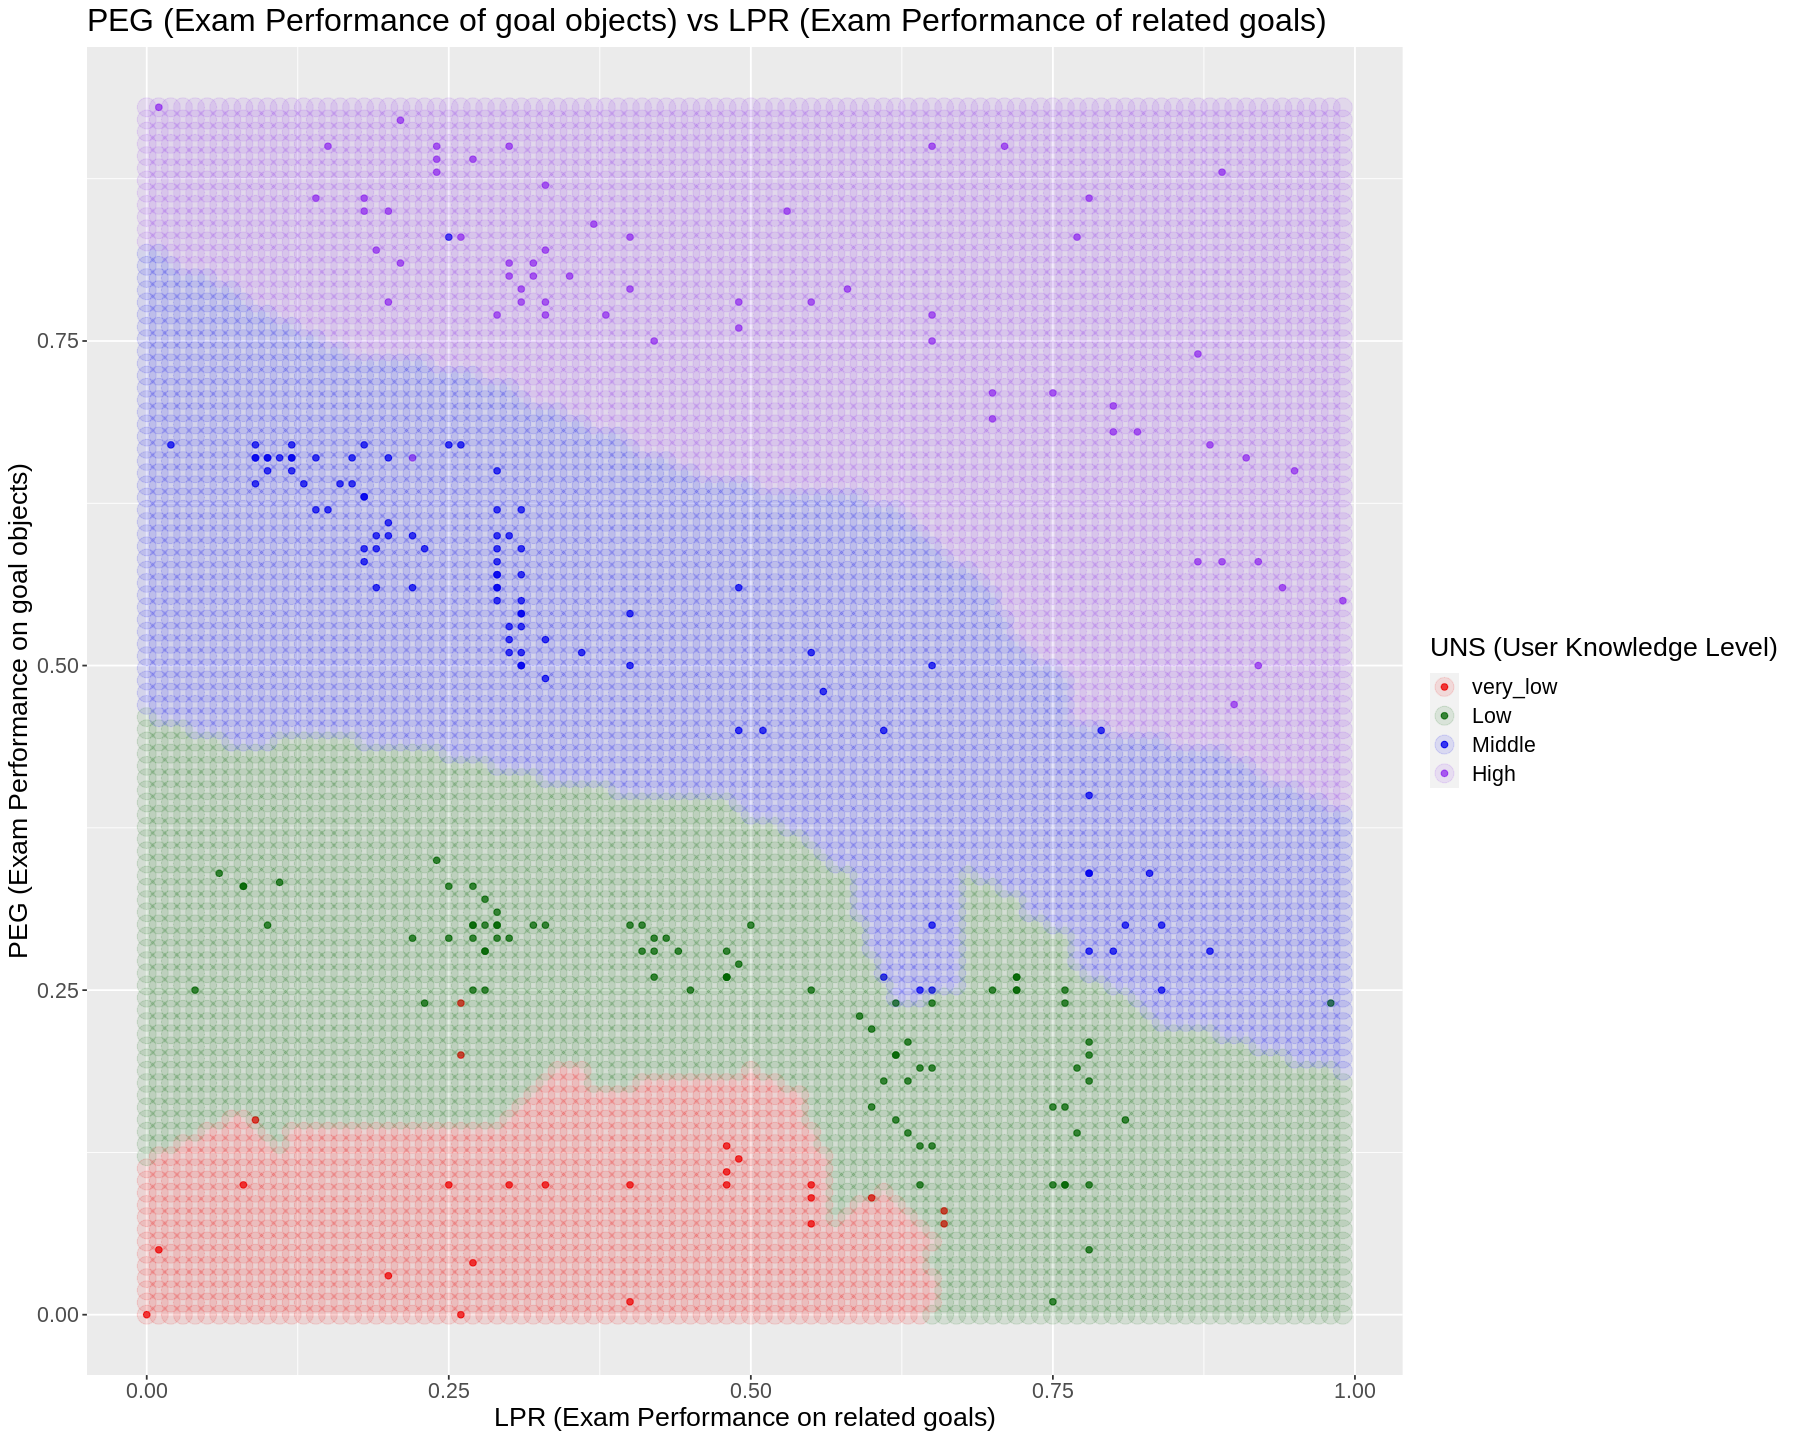

In [75]:
options(repr.plot.width = 15, repr.plot.height = 12)

LPR_grid <- seq(min(user_data$LPR), 
                max(user_data$LPR), 
                length.out = 100)

PEG_grid <- seq(min(user_data$PEG), 
                max(user_data$PEG), 
                length.out = 100)

asgrid <- as_tibble(expand.grid(LPR = LPR_grid, 
                                PEG = PEG_grid))

user_predict <- predict(user_fit, asgrid)

prediction_table <- bind_cols(user_predict, asgrid) %>% 
  rename(UNS = .pred_class)

user_knowledge_graph <- ggplot() +
    geom_point(data = user_data, 
               mapping = aes(x = LPR, 
                             y = PEG, 
                             color = UNS), 
               alpha = 0.75) +
    geom_point(data = prediction_table, 
               mapping = aes(x = LPR, 
                             y = PEG, 
                             color = UNS), 
               alpha = 0.1, 
               size = 5) +
    labs(x = "LPR (Exam Performance on related goals)", 
         y = "PEG (Exam Performance on goal objects)", 
         color = "UNS (User Knowledge Level)") +
    ggtitle("PEG (Exam Performance of goal objects) vs LPR (Exam Performance of related goals)") +
    scale_color_manual(values = c("red2", "darkgreen", "blue2", "purple2")) +
    theme(text = element_text(size = 16))

user_knowledge_graph

This analysis was performed to determine the predicted knowledge level of a student on certain subject matter, based on the exam performance of the user on goal objects and related objects. Through preliminary analysis a strong relationship was found between exam performance on goal objects (PEG) and on related objects (LPR) to the knowledge level of the user (UNS). Because of the patterns present in the data, these variables were used to build our classification model. The model was trained and tuned, using cross validation to select K = 2 as the best parameter, K. 

Once built, the model’s accuracy was assessed on the testing subset of the data, producing an accuracy of 92%. The accuracy of the model was also assessed using different combinations of predictors. The accuracy of our chosen predictors was 20% higher than the accuracy of the model using any other combination of predictors. A confusion matrix was made to provide better insight on the correct and incorrect predictions of classes. Most mistakes were made with very low and low classes, where very low was confused for low types. These mistakes may have been due to the slight class imbalance of the very low class, or likely because the grouping of the data was slightly less defined at lower PEG scores on the PEG vs LPR scatter plot. From the accuracy and confusion matrix, we conclude that this classification model is able to effectively predict the knowledge level of a user. 

This conclusion is somewhat unexpected, based on the informed assumption that test scores alone are not an effective way of measuring student knowledge (Schneider, 2017). However, these results did confirm the ideas introduced by Ley, T. & Kump, B., (2013), that knowledge level can depend on predictors which are both directly and indirectly related to the subject of focus. This finding could have applications when trying to maximize students’ knowledge levels: a broader learning approach could be taken where focus is placed on a wider range of topics which have applications to the subject of focus, promoting more well-rounded learning. 

Different perspectives may be gained if the knowledge levels considered were assigned by student’s themselves. We could explore if this altered target variable has a stronger relationship with predictors such as study time or degree of repetition, as it represents student’s own opinions of their level of understanding. Comparing these findings could give insight on the discrepancies between expected performance and actual performance of students.

We could also consider this data set, excluding predictors pertaining to exam performance. The relationships between other variables were much weaker, so the classifier may have lower accuracy, but this model could be used to predict the knowledge level of a student prior to any information being collected on exam performance. 


## **Citations**
Ley, T., & Kump, B. (2013). Which User Interactions Predict Levels of Expertise in Work-Integrated Learning? In Scaling up Learning for Sustained Impact (Vol. 8095, pp. 178–190). essay, Springer, Berlin, Heidelberg. Retrieved April 9, 2022, from https://link.springer.com/chapter/10.1007/978-3-642-40814-4_15

Schneider, J. (2017). Wrong Answer: Standardized Tests and Their Limitations. In Beyond test scores: A better way to measure school quality (pp. 14–51). essay, Harvard University Press. 

Kahraman, H. T., Colak, I., & Sagiroglu, S. (2009, October). User Knowledge Modeling Data Set. UCI Machine Learning Repository. Retrieved April 9, 2022, from https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling# 